In [61]:
import os
import numpy as np
import pandas as pd
import datetime

# data processing libs
import rasterio as rio
import xarray as xr
import rioxarray
import json
import requests
from pyproj import CRS
import pyproj

from osgeo import gdal
from math import ceil, floor

# plotting libs
import matplotlib.pyplot as plt

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
from odc.stac import stac_load
import planetary_computer
import pystac_client
import rich.table
import warnings
warnings.filterwarnings("ignore")

In [62]:
###### CHANGE HERE ###########
network_name = "various-geographic-locations"
###### CHANGE HERE ###########

input_path = r"..\1_data"
output_path = r"..\3_data_out"
appears_path = "APPEEARS_subsetting"
SMAPL3_path = "SPL3SMP_E"
SMAPL4_path = "SPL4SMGP"
SMAPL4_grid_path = "SMAPL4SMGP_EASEreference"
MODIS_path = r".\MOD15A2H"
modis_ndvi_path = r".\MODIS_NDVI"
# os.chdir("G:\Shared drives\Ryoko and Hilary\SMSigxSMAP\analysis")

Load Ease grid

In [63]:
fn = "SMAP_L4_SM_lmc_00000000T000000_Vv7032_001.h5"
file_path = os.path.join(input_path, SMAPL4_grid_path, fn)
# if os.path.exists(file_path):
#     print('The file exists')
# else:
#     print('The file does NOT exist')
# print(file_path)
g = gdal.Open(file_path)
# subdatasets = g.GetSubDatasets()

varname_lat = "cell_lat"
full_varname_lat = f'HDF5:"{file_path}"://{varname_lat}'

varname_lon = "cell_lon"
full_varname_lon = f'HDF5:"{file_path}"://{varname_lon}'

varname_ease_column = "cell_column"
full_varname_ease_column = f'HDF5:"{file_path}"://{varname_ease_column}'

varname_ease_row = "cell_row"
full_varname_ease_row = f'HDF5:"{file_path}"://{varname_ease_row}'

ease_lat = rioxarray.open_rasterio(full_varname_lat)
ease_lon = rioxarray.open_rasterio(full_varname_lon)
ease_column = rioxarray.open_rasterio(full_varname_ease_column)
ease_row = rioxarray.open_rasterio(full_varname_ease_row)

Load Appears sample request

In [64]:
file_path = os.path.join(input_path, appears_path, network_name, f'{network_name}-request.json')
with open(file_path, 'r') as infile:
    request_content = json.load(infile)
coordinates = request_content['params']['coordinates']
dates = request_content['params']['dates']
coordinates

[{'id': '0',
  'category': 'Nothern Australia (Tropical dry)',
  'latitude': -15.345077,
  'longitude': 142.94616},
 {'id': '1',
  'category': 'Brazil (Tropical dry)',
  'latitude': -14.139373,
  'longitude': -58.190676},
 {'id': '2',
  'category': 'Virginia (Mid-lat humid)',
  'latitude': 38.966439,
  'longitude': -80.646556},
 {'id': '3',
  'category': 'Wisconsin (Mid-lat humid)',
  'latitude': 45.644185,
  'longitude': -89.904949},
 {'id': '4',
  'category': 'China (Mid-lat humid)',
  'latitude': 34.931655,
  'longitude': 101.70849},
 {'id': '5',
  'category': 'Brazil (Mid-lat humid)',
  'latitude': -7.738738,
  'longitude': -51.667379},
 {'id': '6',
  'category': 'South Dacota (Mid-lat dry)',
  'latitude': 44.770144,
  'longitude': -101.695938},
 {'id': '7',
  'category': 'Zambia (Mid-lat dry)',
  'latitude': -17.037961,
  'longitude': 25.431202},
 {'id': '8',
  'category': 'Argentina (Mid-lat dry)',
  'latitude': -36.019919,
  'longitude': -63.137572},
 {'id': '9',
  'category': '

In [65]:
for i in range(len(coordinates)): 
    target_lat = coordinates[i]['latitude']
    target_lon = coordinates[i]['longitude']
    target_station = coordinates[i]['category'] #.split()[0]
    print(f'processing{i}/{len(coordinates)} station: {target_station}')

    # %%
    distance = np.sqrt((target_lat-ease_lat[0].values)**2+(target_lon-ease_lon[0].values)**2)

    minElement  = np.where(abs(distance) == np.nanmin(abs(distance)))
    # print(np.nanmin(distance))

    if len(minElement[0])!=1:
        print('There are more than two closest cells')
        
    lat_center = ease_lat[0].values[minElement]
    lon_center = ease_lon[0].values[minElement]
    ease_center_column = ease_column[0].values[minElement]
    ease_center_row = ease_row[0].values[minElement]

    print(f'The closest cell to the point ({target_lat}, {target_lon}) is\
        ({lat_center[0]}, {lon_center[0]}:\
        EASE GRID ({ease_center_row[0]}, {ease_center_column[0]})),\
        d={distance[minElement][0]} degrees')

    bbox_lat_max = (ease_lat[0].values[minElement]+ease_lat[0].values[minElement[0][0]-1][minElement[1][0]])/2
    bbox_lat_min = (ease_lat[0].values[minElement]+ease_lat[0].values[minElement[0][0]+1][minElement[1][0]])/2
    bbox_lon_max = (ease_lon[0].values[minElement]+ease_lon[0].values[minElement[0][0]][minElement[1][0]+1])/2
    bbox_lon_min = (ease_lon[0].values[minElement]+ease_lon[0].values[minElement[0][0]][minElement[1][0]-1])/2

    bounding_box = f'{bbox_lon_min[0]},{bbox_lat_min[0]},{bbox_lon_max[0]},{bbox_lat_max[0]}'
    # print(bounding_box)

    # %%
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )


    def float_round(num, places = 0, direction = floor):
        return direction(num * (10**places)) / float(10**places)

    buffer=0.2
    bbox = [bbox_lon_min[0]-buffer, bbox_lat_min[0]-buffer, bbox_lon_max[0]+buffer, bbox_lat_max[0]+buffer]
    bbox = [float_round(x, 10, round)for x in bbox] 
    # print(bbox)
    year = "2019"
    months = {
        "February": "2",
    }

    # Change this 
    time_range = "2015-03-31/2022-03-30" #"2019-03-01/2019-04-30" # "2015-03-31/2022-03-30" # 

    search = catalog.search(
        collections=["modis-13A1-061"],
        bbox=bbox,
        datetime=time_range,
    )
    items = list(search.get_items())
    print(f"Found: {len(items):d} datasets")
    items_dict = dict()
    for i, item in enumerate(items):
        items_dict[i] = item

        # %% [markdown]
    # ### Get the MODIS composite for a day, and get the average over the EASE grid

    # %%
    # Get the unique dates from the list of items 
    unique_dates = []
    for i in range(len(items)):
        split_itemid = str(items[i]).split(".")
        unique_dates.append(split_itemid[1])
    unique_dates = set(unique_dates)

    # Iterate through the unique dates 
    for i, unique_date in enumerate(unique_dates):
        item_for_the_unique_date = []
        print(f'processing{i}/{len(unique_dates)}: {unique_date}')
        
        # Create a paired list of granules for the unique date
        for j, item in enumerate(items):
            if (unique_date in str(item)): 
                item_for_the_unique_date.append(item)
        
        # Iterate through the list of granules for the unique date 
        for k, item in enumerate(item_for_the_unique_date):
            
            # Read MODIS data from STAC server
            MODIS_data0 = stac_load(
                [item],
                crs="EPSG:4326",
                bands="500m_16_days_NDVI",
                resolution=0.0045,
                bbox=bbox
            )

            MODIS_QA0 = stac_load(
                [item],
                crs="EPSG:4326",
                bands="500m_16_days_pixel_reliability",
                resolution=0.0045,
                bbox=bbox
            )

            # MODIS_QA = MODIS_QA0['500m_16_days_pixel_reliability']
            
            # Scale the data 
            raster = item.assets["500m_16_days_NDVI"].extra_fields["raster:bands"]
            MODIS_data = MODIS_data0["500m_16_days_NDVI"] * raster[0]["scale"]
            # https://lpdaac.usgs.gov/documents/621/MOD13_User_Guide_V61.pdf

            # -1 Fill/No Data Not Processed
            # 0 Good Data Use with confidence
            # 1 Marginal data Useful, but look at other QA information
            # 2 Snow/Ice Target covered with snow/ice
            # 3 Cloudy Target not visible, covered with cloud
            # 4 Estimated From MODIS historic time series

            # Merge the data 
            if k==0:
                MODIS_dataset = MODIS_data
                MODIS_QAset = MODIS_QA0['500m_16_days_pixel_reliability']
            else:
                MODIS_dataset = MODIS_dataset.combine_first(MODIS_data)
                MODIS_QAset = MODIS_QAset.combine_first(MODIS_QA0['500m_16_days_pixel_reliability'])
            
            MODIS_dataset = MODIS_dataset.where(MODIS_QAset==0)
            # MODIS_dataset.plot.imshow(cmap="viridis", col="time")

            # Take an average over the grid
            if k==len(item_for_the_unique_date)-1:
                MODIS_dataset = MODIS_dataset.rename({'longitude': 'x', 'latitude': 'y'})
                MODIS_dataset_clipped = MODIS_dataset.rio.clip_box(minx=bbox_lon_min[0], miny=bbox_lat_min[0], maxx=bbox_lon_max[0], maxy=bbox_lat_max[0]).copy()
                # MODIS_dataset.plot.imshow(cmap="viridis", col="time", vmin=0, vmax=1)
                # MODIS_dataset_clipped.plot.imshow(cmap="viridis", col="time", vmin=0, vmax=1)
                mean_over_SMAPgrid0 = MODIS_dataset.mean(dim=["x", "y"],skipna=True)
                mean_over_SMAPgrid1 = pd.DataFrame([[mean_over_SMAPgrid0.time.values[0], mean_over_SMAPgrid0.values[0]]], columns=['Date', 'MODISmeanNDVI_SMAPgrid'])
                mean_over_SMAPgrid1['Date'] = pd.to_datetime(mean_over_SMAPgrid1['Date'])
                mean_over_SMAPgrid1.set_index('Date', inplace=True)
                if i==0:
                    mean_ts = mean_over_SMAPgrid1
                else:
                    mean_ts = pd.concat([mean_ts, mean_over_SMAPgrid1])

    mean_ts_daily = mean_ts['MODISmeanNDVI_SMAPgrid'].resample('D', axis=0).interpolate()
    mean_ts_daily.plot()

    if not os.path.exists(os.path.join(input_path, modis_ndvi_path, network_name.replace(" ", "_"))):
        os.makedirs(os.path.join(input_path, modis_ndvi_path, network_name.replace(" ", "_")))
    file_path = os.path.join(input_path, modis_ndvi_path, network_name.replace(" ", "_"), f'daily_NDVI_{target_station}.csv')
    mean_ts_daily.to_csv(file_path, header=True, index=True)              


processing9/10 station: Russia (Mid-lat humid)


## Get corresponding EASE grid to the sample request

The closest cell to the point (56.148147, 73.041933) is    (56.09038543701172, 73.05498504638672:    EASE GRID (136, 2710)),    d=0.05921882763504982 degrees


## 3. Get MODIS data
## 3.1. Read catalog of MODIS data

Found: 658 datasets


processing0/9: A2019105
processing1/9: A2019065
processing2/9: A2019057
processing3/9: A2019113
processing4/9: A2019089
processing5/9: A2019081
processing6/9: A2019049
processing7/9: A2019097
processing8/9: A2019073


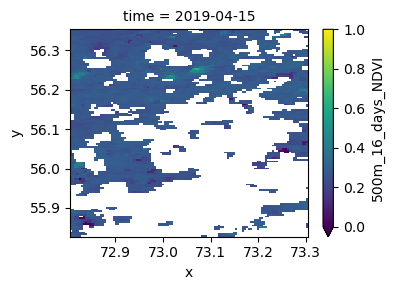

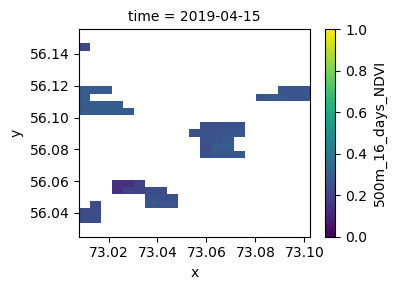

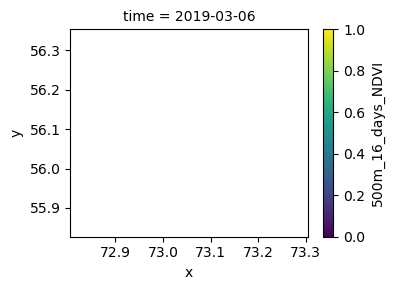

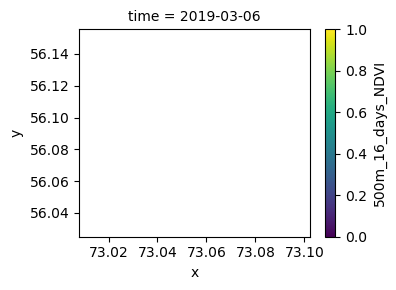

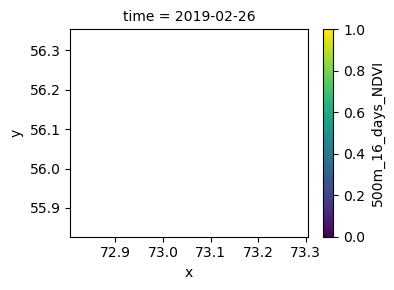

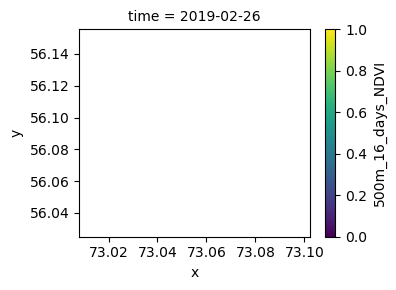

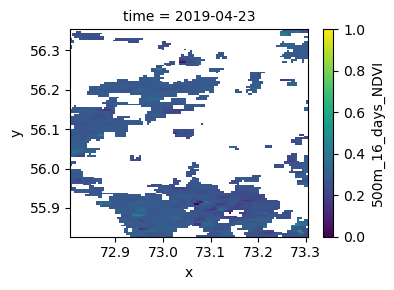

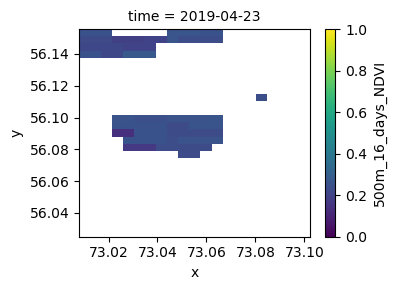

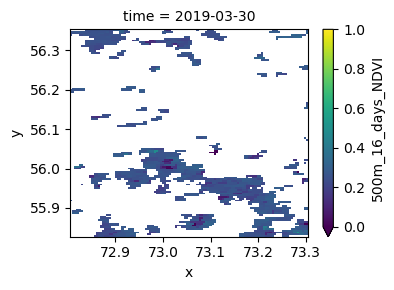

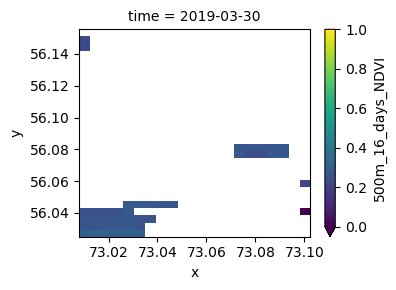

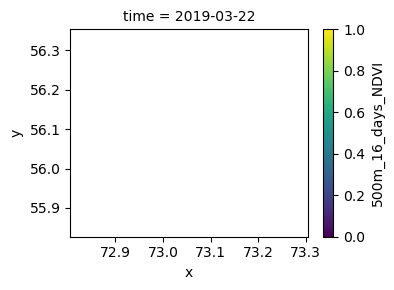

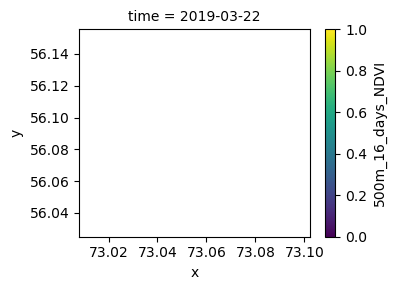

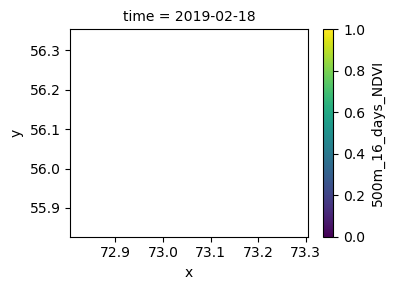

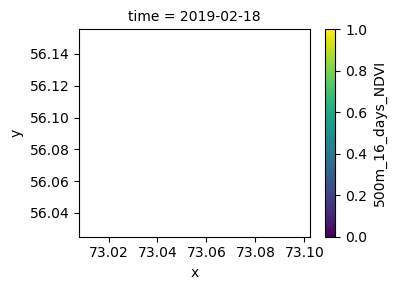

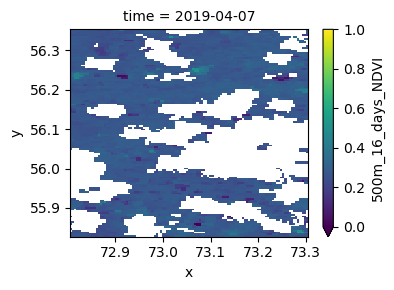

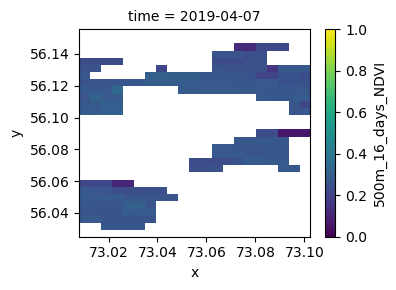

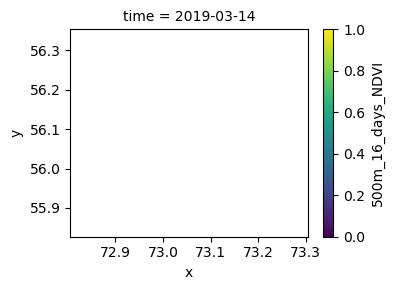

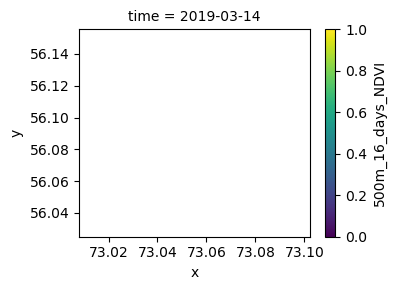

Get timeseries of the sampled NDVI

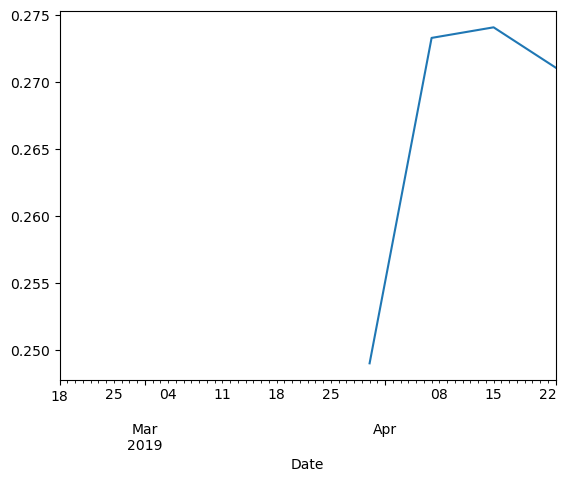